In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing necessary packages**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## **2. Load the Image Training and Validation Datasets**

### i. Get the Image Dataset Paths

In [ ]:
train_dataset_path = '/content/drive/MyDrive/FYP/train'
validation_dataset_path = '/content/drive/MyDrive/FYP/val'

### ii. Load Image Datasets and Apply Augmentations
Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [ ]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 16

Loading the training dataset and applying augmentations on it.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                   rotation_range=10,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                   horizontal_flip=True,
                                    shear_range=0.2,
                                  vertical_flip=True,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 1325 images belonging to 2 classes.


Loading the validation dataset.

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 250 images belonging to 2 classes.


### iii. Get the Label Mappings
The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Nonnude
1 : Nude


## **3. Plotting Sample Training Image**s

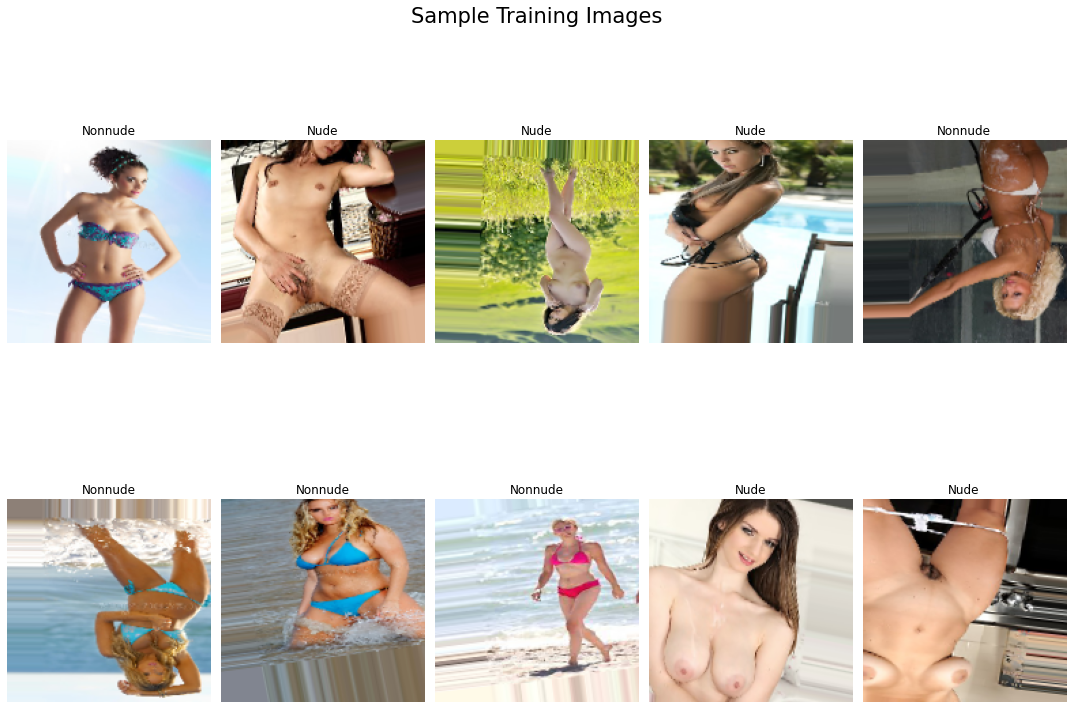

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()


## **4. Training a CNN Model**
Since the training dataset is ready let's create a simple CNN Model to train on the image datasets

### i. Create a CNN Model

In [ ]:
cnn_model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dense(2, activation='softmax')
])


In [ ]:
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

### ii. Defining Callbacks
A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

a. Reduce Learning Rate on Plateau
Is used to reduce the learning rate when a metric has stopped improving.

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

### iii. Defining the Optimizer

In [ ]:
optimizer = Adam(learning_rate=0.001)
# from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)


In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      # tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      # tf.keras.metrics.F1Score(name='F1'),
      tfa.metrics.F1Score(num_classes= 2,name="f1_Score")

    
]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### iv. Compile the Model

In [ ]:
cnn_model.compile(optimizer=sgd, loss=CategoricalCrossentropy(),metrics=METRICS)

### v. Training the Model

In [ ]:
history = cnn_model.fit_generator(train_generator, steps_per_epoch=15, epochs=30 ,validation_steps=2, validation_data=validation_generator
                       ,verbose=2 ,callbacks=[reduce_lr]  )


Epoch 1/30
15/15 - 104s - loss: 0.6790 - accuracy: 0.5625 - precision: 0.5625 - recall: 0.5625 - auc: 0.5985 - f1_Score: 0.4291 - val_loss: 0.4700 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_Score: 0.5000 - lr: 0.0010 - 104s/epoch - 7s/step
Epoch 2/30
15/15 - 57s - loss: 0.6611 - accuracy: 0.6269 - precision: 0.6269 - recall: 0.6269 - auc: 0.6252 - f1_Score: 0.3853 - val_loss: 0.4364 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_Score: 0.5000 - lr: 0.0010 - 57s/epoch - 4s/step
Epoch 3/30
15/15 - 37s - loss: 0.6487 - accuracy: 0.6458 - precision: 0.6458 - recall: 0.6458 - auc: 0.6623 - f1_Score: 0.3924 - val_loss: 0.4275 - val_accuracy: 0.9844 - val_precision: 0.9844 - val_recall: 0.9844 - val_auc: 0.9875 - val_f1_Score: 0.4961 - lr: 0.0010 - 37s/epoch - 2s/step
Epoch 4/30
15/15 - 26s - loss: 0.6662 - accuracy: 0.6042 - precision: 0.6042 - recall: 0.6042 - auc: 0.6441 - f1_Score: 0.3766 -

## **5. Plotting the Model Metrics**
### i. Plotting training and validation accuracy, loss and learning rate

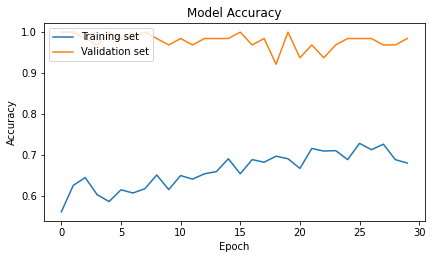

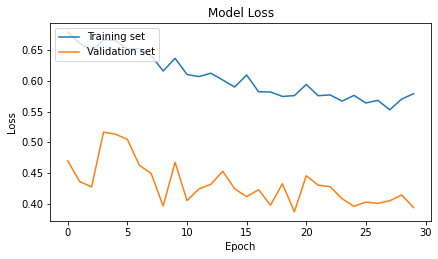

In [ ]:
model=cnn_model
plt.figure( figsize = (15,8)) 
    
plt.subplot(221)  
# Accuracy 
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


# Loss
plt.figure( figsize = (15,8)) 
plt.subplot(222)  
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [ ]:
train_accuracy = history.history['accuracy']
train_accuracy

[0.5625,
 0.6268980503082275,
 0.6458333134651184,
 0.6041666865348816,
 0.5874999761581421,
 0.6160520315170288,
 0.6083333492279053,
 0.6187499761581421,
 0.6520833373069763,
 0.6166666746139526,
 0.650759220123291,
 0.6420824527740479,
 0.6550976037979126,
 0.6604166626930237,
 0.6916666626930237,
 0.6550976037979126,
 0.6895833611488342,
 0.6832971572875977,
 0.6979166865348816,
 0.6916666626930237,
 0.6681128144264221,
 0.7166666388511658,
 0.7104166746139526,
 0.7114967703819275,
 0.6895833611488342,
 0.7291666865348816,
 0.7136659622192383,
 0.7270833253860474,
 0.6895833611488342,
 0.6812499761581421]

In [ ]:
val_accuracy = history.history['val_accuracy']
val_accuracy

[1.0,
 1.0,
 0.984375,
 0.96875,
 1.0,
 0.984375,
 0.984375,
 1.0,
 0.984375,
 0.96875,
 0.984375,
 0.96875,
 0.984375,
 0.984375,
 0.984375,
 1.0,
 0.96875,
 0.984375,
 0.921875,
 1.0,
 0.9375,
 0.96875,
 0.9375,
 0.96875,
 0.984375,
 0.984375,
 0.984375,
 0.96875,
 0.96875,
 0.984375]

In [ ]:
train_loss = history.history['loss']
train_loss

[0.6789721250534058,
 0.6611093282699585,
 0.6487389802932739,
 0.666168749332428,
 0.665343701839447,
 0.652012825012207,
 0.6520705819129944,
 0.6405843496322632,
 0.6158680319786072,
 0.6364526152610779,
 0.6101543307304382,
 0.6067559123039246,
 0.6122265458106995,
 0.6011428833007812,
 0.5898469686508179,
 0.6092977523803711,
 0.5821501612663269,
 0.5817273855209351,
 0.5745489597320557,
 0.5758044123649597,
 0.5940016508102417,
 0.5757048726081848,
 0.5770201086997986,
 0.5669118762016296,
 0.5762094855308533,
 0.5639312863349915,
 0.5682066082954407,
 0.5527903437614441,
 0.5703293681144714,
 0.5790107846260071]

In [ ]:
learning_rate = history.history['lr']

val_loss = history.history['val_loss']

val_loss

[0.4699726700782776,
 0.43644389510154724,
 0.4275343418121338,
 0.5166218280792236,
 0.5132622718811035,
 0.5049804449081421,
 0.4628522992134094,
 0.4492129683494568,
 0.39659470319747925,
 0.4675513505935669,
 0.4053954482078552,
 0.42433422803878784,
 0.43195927143096924,
 0.4530283808708191,
 0.4245207905769348,
 0.41182270646095276,
 0.4231388568878174,
 0.39786988496780396,
 0.4327043890953064,
 0.3872024416923523,
 0.44573232531547546,
 0.4304324984550476,
 0.42801064252853394,
 0.4085690379142761,
 0.39613014459609985,
 0.40300822257995605,
 0.4009172320365906,
 0.4051099717617035,
 0.414463073015213,
 0.39407020807266235]

In [ ]:
ans = history.history['val_auc']

ans

[1.0,
 1.0,
 0.987548828125,
 0.99609375,
 1.0,
 0.986572265625,
 0.9892578125,
 1.0,
 0.99755859375,
 0.989501953125,
 0.998291015625,
 0.98974609375,
 0.999755859375,
 0.9990234375,
 0.99072265625,
 1.0,
 0.9970703125,
 0.999267578125,
 0.984130859375,
 1.0,
 0.987548828125,
 0.998046875,
 0.9952392578125,
 0.998046875,
 0.9990234375,
 0.99755859375,
 0.9998779296875,
 0.99658203125,
 0.995361328125,
 0.998779296875]

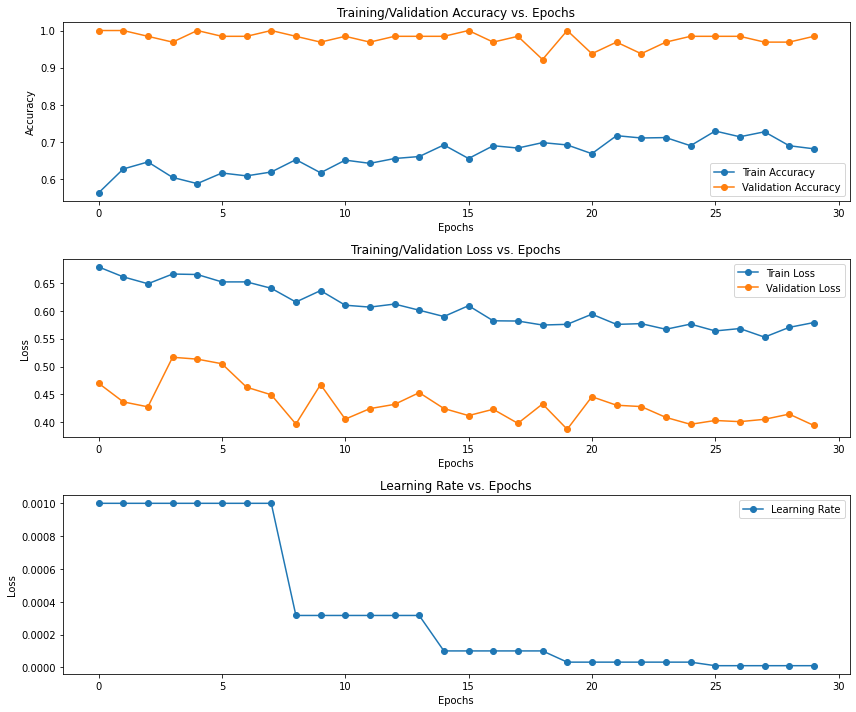

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training/Validation Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

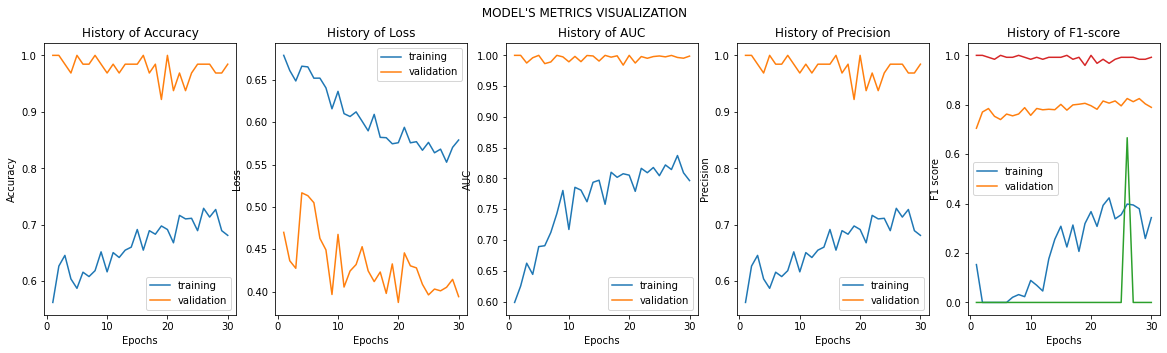

In [ ]:

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1_Score,val_f1_Score):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1_Score) + 1), f1_Score)
    ax5.plot(range(1, len(val_f1_Score) + 1), val_f1_Score)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    
import numpy as np
# f1_s= np.mean(history.history['f1_Score'])
# val_f1_s= np.mean(history.history['val_f1_Score'])
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
              #  f1_s,val_f1_s

                , history.history['f1_Score'],history.history['val_f1_Score']
              )


## 6. Testing the Model on Test Set
Testing the model on the validation dataset because a seperate dataset for testing is not available.


In [ ]:
test_dataset = '/content/drive/MyDrive/FYP/test'

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 128 images belonging to 2 classes.


## 7. Model Prediction on the Test Dataset

In [ ]:
predictions = cnn_model.predict(test_generator)

4/4 [==============================] - 1s 153ms/step


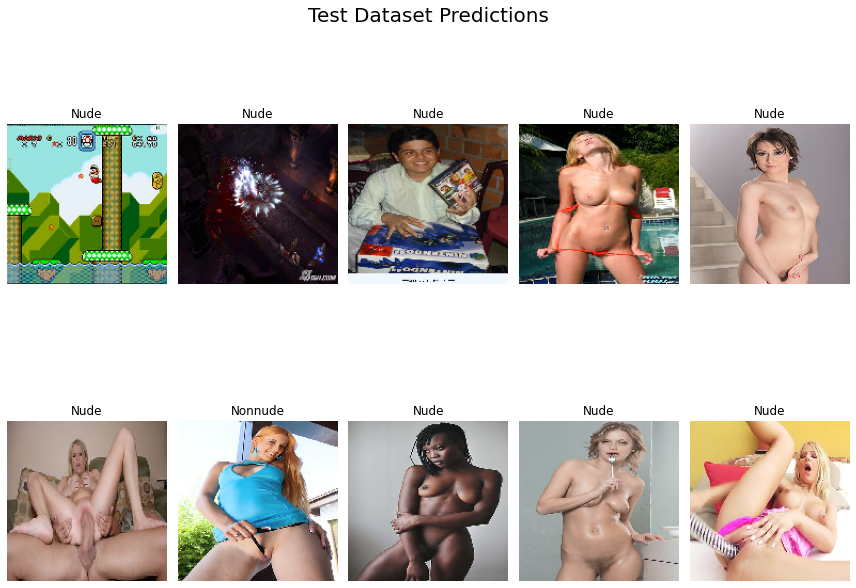

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
train_loss, train_accuracy, train_precision, train_recall, train_auc, train_F1_Score = cnn_model.evaluate(train_generator, batch_size=BATCH_SIZE)

42/42 [==============================] - 18s 423ms/step - loss: 0.5734 - accuracy: 0.6951 - precision: 0.6951 - recall: 0.6951 - auc: 0.8052 - f1_Score: 0.5698


In [ ]:
print(f"Train Loss:     {train_loss*100}")
print(f"Train Accuracy: {train_accuracy* 100}")
print(f"Train Precision: {train_precision* 100}")
print(f"Train Recall: {train_recall* 100}")
print(f"Train AUC: {train_auc* 100}")
print(f"Train F1_Score: {np.mean(train_F1_Score)* 100}")


Train Loss:     57.340431213378906
Train Accuracy: 69.5094347000122
Train Precision: 69.5094347000122
Train Recall: 69.5094347000122
Train AUC: 80.52490949630737
Train F1_Score: 56.98328614234924


In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_F1_Score = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)


4/4 [==============================] - 1s 249ms/step - loss: 0.4013 - accuracy: 0.9609 - precision: 0.9609 - recall: 0.9609 - auc: 0.9953 - f1_Score: 0.4900


In [ ]:
print(f"Test Loss:     {test_loss* 100}")
print(f"Test Accuracy: {test_accuracy* 100}")
print(f"Test Precision: {test_precision* 100}")
print(f"Test Recall: {test_recall* 100}")
print(f"Test AUC: {test_auc* 100}")
print(f"Test F1_Score: {np.mean(test_F1_Score)* 100}")


Test Loss:     40.126919746398926
Test Accuracy: 96.09375
Test Precision: 96.09375
Test Recall: 96.09375
Test AUC: 99.530029296875
Test F1_Score: 49.00398254394531


## **8. Plotting the Classification Metrics**
### i. Confusion Matrix

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

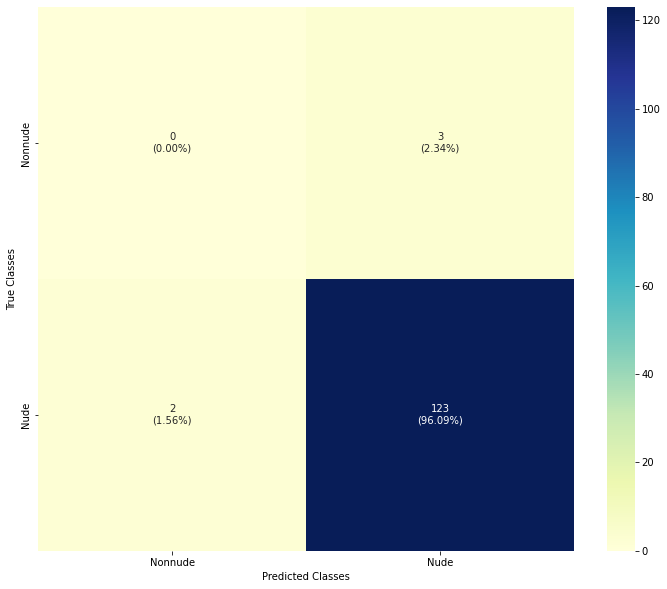

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

     Nonnude       0.00      0.00      0.00         3
        Nude       0.98      0.98      0.98       125

    accuracy                           0.96       128
   macro avg       0.49      0.49      0.49       128
weighted avg       0.95      0.96      0.96       128



In [ ]:
A=history.history['accuracy']
A_v=history.history['val_accuracy']
L=history.history['loss']
L_v=history.history['val_loss']
Auc=history.history['auc']
Auc_v=history.history['val_auc']
P=history.history['precision']
P_v=history.history['val_precision']
F1=history.history['f1_Score']
F1_v=history.history['val_f1_Score']

In [ ]:
import pandas as pd
data_to_submit = pd.DataFrame({
    'accuracy':A,
    'val_accuracy':A_v,
    'loss': L,
    'val_loss': L_v,
    'auc':Auc,
    'val_auc':Auc_v,
    'precision':P,
    'val_precision':P_v,
    'f1_score':F1,
    'val_f1_score':F1_v
})
data_to_submit.to_csv('csv_to_submit.csv', index = False)